[*********************100%%**********************]  1 of 1 completed


Epoch 1/10
904/904 [==============================] - 34s 34ms/step - loss: 0.0018
Epoch 2/10
904/904 [==============================] - 30s 33ms/step - loss: 6.1936e-04
Epoch 3/10
904/904 [==============================] - 27s 30ms/step - loss: 5.4402e-04
Epoch 4/10
904/904 [==============================] - 28s 31ms/step - loss: 4.6239e-04
Epoch 5/10
904/904 [==============================] - 28s 31ms/step - loss: 3.3546e-04
Epoch 6/10
904/904 [==============================] - 32s 36ms/step - loss: 3.2932e-04
Epoch 7/10
904/904 [==============================] - 27s 30ms/step - loss: 3.0655e-04
Epoch 8/10
904/904 [==============================] - 28s 31ms/step - loss: 2.4352e-04
Epoch 9/10
904/904 [==============================] - 27s 30ms/step - loss: 2.8102e-04
Epoch 10/10
2/2 [==============================] - 1s 16ms/step


<ipython-input-8-aa8c914ee906>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


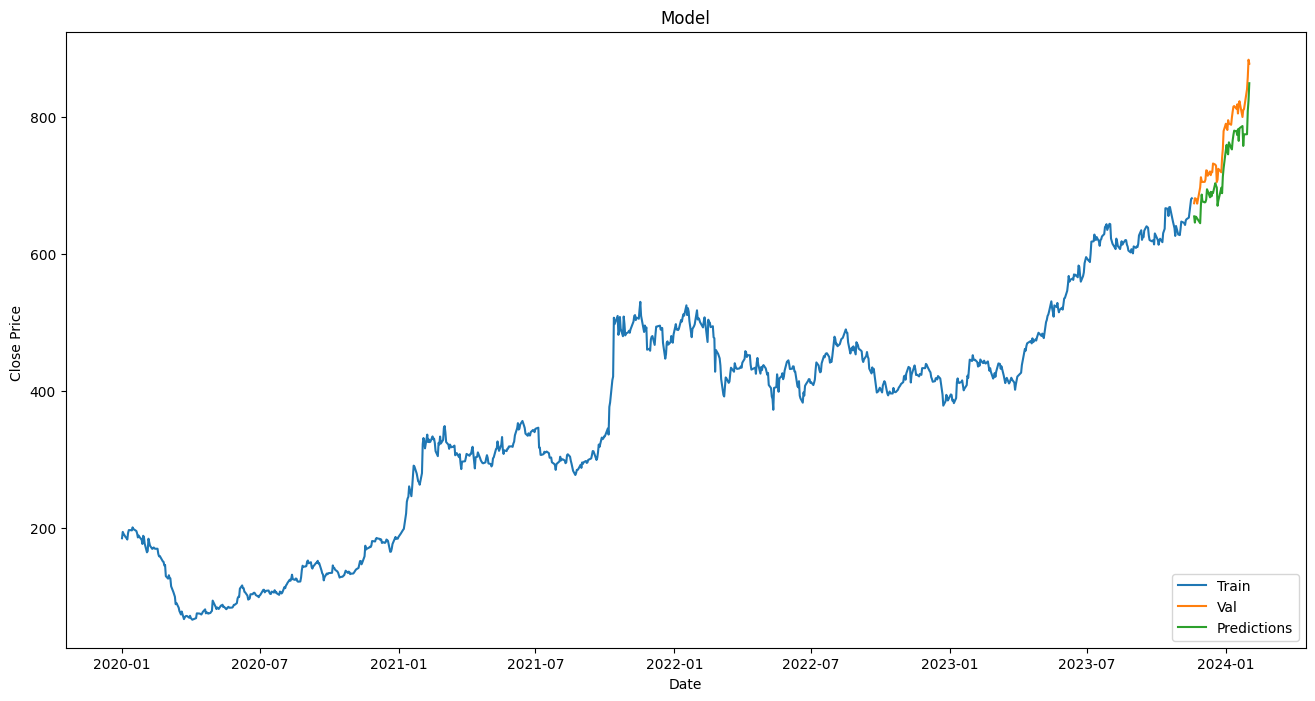

LSTM MSE: 1423.5959269223363
LSTM R2: 0.5505189690416152


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score

# Function to fetch historical stock data
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Function to prepare data for LSTM
def prepare_data(data, window_size=1600):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    training_data_len = int(np.ceil(len(scaled_data) * .95))

    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []

    for i in range(window_size, len(train_data)):
        x_train.append(train_data[i-window_size:i, 0])
        y_train.append(train_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    return x_train, y_train, scaler, training_data_len, scaled_data

# Function to build and train the LSTM model
def build_lstm_model(x_train):
    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

# Main function for stock price prediction
def predict_stock_price(ticker, start_date, end_date, window_size=60):  # Add window_size as an argument
    # Fetch historical stock data
    stock_data = get_stock_data(ticker, start_date, end_date)

    # Prepare data for LSTM
    x_train, y_train, scaler, training_data_len, scaled_data = prepare_data(stock_data, window_size)  # Pass window_size

    # Build and train the LSTM model
    model = build_lstm_model(x_train)
    model.fit(x_train, y_train, batch_size=1, epochs=10)

    # Create the testing data set
    test_data = scaled_data[training_data_len - window_size:, :]

    x_test = []
    y_test = stock_data['Close'][training_data_len:].values

    for i in range(window_size, len(test_data)):
        x_test.append(test_data[i - window_size:i, 0])

    x_test = np.array(x_test)

    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Get the predicted stock price values
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Plot the data
    train = stock_data[:training_data_len]
    valid = stock_data[training_data_len:]
    valid['Predictions'] = predictions

    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date')
    plt.ylabel('Close Price ')
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()
    print("LSTM MSE:", mean_squared_error(y_test, predictions))
    print("LSTM R2:", r2_score(y_test, predictions))
if __name__ == "__main__":
    ticker_symbol = 'TATAMOTORS.NS'
    start_date = '2020-01-01'
    end_date = '2024-02-02'

    predict_stock_price(ticker_symbol, start_date, end_date)

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Download stock data from Yahoo Finance
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Feature engineering
def create_features(data):
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['Daily_Return'] = data['Close'].pct_change()
    data.dropna(inplace=True)
    return data

# Split data into train and test sets
def split_data(data, test_size=0.2):
    X = data[['SMA_50', 'SMA_200', 'Daily_Return']]
    y = data['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

# Linear Regression model
def linear_regression_model(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Random Forest model
def random_forest_model(X_train, y_train, X_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Support Vector Regressor model
def svr_model(X_train, y_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVR(kernel='linear')
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    return predictions

# LSTM neural network model
def lstm_model(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    X_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)

    predictions = model.predict(X_test)
    predictions = predictions.reshape(-1)
    return predictions

# Main function
def main():
    ticker = 'GC=F'
    start_date = '2010-01-01'
    end_date = '2024-01-26'

    stock_data = download_stock_data(ticker, start_date, end_date)
    stock_data = create_features(stock_data)
    X_train, X_test, y_train, y_test = split_data(stock_data)

    # Linear Regression
    lr_predictions = linear_regression_model(X_train, y_train, X_test)

    # Random Forest
    rf_predictions = random_forest_model(X_train, y_train, X_test)

    # SVR
    svr_predictions = svr_model(X_train, y_train, X_test)

    # LSTM
    lstm_predictions = lstm_model(X_train, y_train, X_test)

    # Evaluate models
    print("Linear Regression MSE:", mean_squared_error(y_test, lr_predictions))
    print("Linear Regression R2:", r2_score(y_test, lr_predictions))
    print("Random Forest MSE:", mean_squared_error(y_test, rf_predictions))
    print("Random Forest R2:", r2_score(y_test, rf_predictions))
    print("SVR MSE:", mean_squared_error(y_test, svr_predictions))
    print("SVR R2:", r2_score(y_test, svr_predictions))
    print("LSTM MSE:", mean_squared_error(y_test, lstm_predictions))
    print("LSTM R2:", r2_score(y_test, lstm_predictions))

if __name__ == "__main__":
    main()


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed


21/21 [==============================] - 0s 3ms/step
Linear Regression MSE: 2845.7082665684825
Linear Regression R2: 0.9599489845402088
Random Forest MSE: 375.77523562157023
Random Forest R2: 0.9947112710223686
SVR MSE: 7155.515240488278
SVR R2: 0.8992919777173263
LSTM MSE: 2962.1138224662645
LSTM R2: 0.9583106715853501


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Download stock data from Yahoo Finance
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Feature engineering
def create_features(data):
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['Daily_Return'] = data['Close'].pct_change()
    data.dropna(inplace=True)
    return data

# Split data into train and test sets
def split_data(data, test_size=0.2):
    X = data[['SMA_50', 'SMA_200', 'Daily_Return']]
    y = data['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

# Linear Regression model
def linear_regression_model(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Ridge Regression model
def ridge_regression_model(X_train, y_train, X_test):
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Lasso Regression model
def lasso_regression_model(X_train, y_train, X_test):
    model = Lasso(alpha=0.01)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Random Forest model
def random_forest_model(X_train, y_train, X_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Gradient Boosting Regressor model
def gradient_boosting_model(X_train, y_train, X_test):
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Support Vector Regressor model
def svr_model(X_train, y_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVR(kernel='linear')
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    return predictions

# Huber Regressor model
def huber_regression_model(X_train, y_train, X_test):
    model = HuberRegressor(epsilon=1.35)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# LSTM neural network model
def lstm_model(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    X_train = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

    model.fit(X_train, y_train, epochs=500, batch_size=32, verbose=0)

    predictions = model.predict(X_test)
    predictions = predictions.reshape(-1)
    return predictions

# Decision Tree Regressor model
def decision_tree_model(X_train, y_train, X_test):
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# K-Nearest Neighbors Regressor model
def knn_model(X_train, y_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    return predictions


# Main function
def main():
    ticker = 'GC=F'
    start_date = '2010-01-01'
    end_date = '2024-01-26'

    stock_data = download_stock_data(ticker, start_date, end_date)
    stock_data = create_features(stock_data)
    X_train, X_test, y_train, y_test = split_data(stock_data)

    # Linear Regression
    lr_predictions = linear_regression_model(X_train, y_train, X_test)

    # Ridge Regression
    ridge_predictions = ridge_regression_model(X_train, y_train, X_test)

    # Lasso Regression
    lasso_predictions = lasso_regression_model(X_train, y_train, X_test)

    # Random Forest
    rf_predictions = random_forest_model(X_train, y_train, X_test)

    # Gradient Boosting
    gb_predictions = gradient_boosting_model(X_train, y_train, X_test)

    # SVR
    svr_predictions = svr_model(X_train, y_train, X_test)

    # Huber Regressor
    huber_predictions = huber_regression_model(X_train, y_train, X_test)

    # LSTM
    lstm_predictions = lstm_model(X_train, y_train, X_test)

     # Decision Tree Regressor
    dt_predictions = decision_tree_model(X_train, y_train, X_test)

    # K-Nearest Neighbors Regressor
    knn_predictions = knn_model(X_train, y_train, X_test)
 # Evaluate models
    models = ["Linear Regression", "Random Forest", "SVR", "LSTM", "Ridge Regression",
              "Lasso Regression", "Gradient Boosting", "Huber Regressor",
              "Decision Tree", "K-Nearest Neighbors"]

    predictions_list = [lr_predictions, rf_predictions, svr_predictions, lstm_predictions,
                        ridge_predictions, lasso_predictions, gb_predictions, huber_predictions,
                        dt_predictions, knn_predictions]

    mse_list = [mean_squared_error(y_test, pred) for pred in predictions_list]
    r2_list = [r2_score(y_test, pred) for pred in predictions_list]

    # Create DataFrame
    results_df = pd.DataFrame({"Model": models, "MSE": mse_list, "R2 Score": r2_list})
    # Sort the DataFrame by R2 score in descending order
    results_df = results_df.sort_values(by='R2 Score', ascending=False)
    # Display the sorted DataFrame
    print(results_df)

if __name__ == "__main__":
    main()

[*********************100%%**********************]  1 of 1 completed


21/21 [==============================] - 0s 2ms/step
                 Model          MSE  R2 Score
1        Random Forest   375.775236  0.994711
8        Decision Tree   705.107699  0.990076
9  K-Nearest Neighbors  1585.618379  0.977684
6    Gradient Boosting  2801.836067  0.960566
5     Lasso Regression  2841.830522  0.960004
0    Linear Regression  2845.708267  0.959949
4     Ridge Regression  2911.691940  0.959020
7      Huber Regressor  2992.094721  0.957889
3                 LSTM  3080.034808  0.956651
2                  SVR  7155.515240  0.899292


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

# Download stock data from Yahoo Finance
def download_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Feature engineering
def create_features(data):
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['Daily_Return'] = data['Close'].pct_change()
    data.dropna(inplace=True)
    return data

# Split data into train and test sets
def split_data(data, test_size=0.2):
    X = data[['SMA_50', 'SMA_200', 'Daily_Return']]
    y = data['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

# Linear Regression model
def linear_regression_model(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Ridge Regression model
def ridge_regression_model(X_train, y_train, X_test):
    model = Ridge(alpha=1.0)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Lasso Regression model
def lasso_regression_model(X_train, y_train, X_test):
    model = Lasso(alpha=0.01)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Random Forest model
def random_forest_model(X_train, y_train, X_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Gradient Boosting Regressor model
def gradient_boosting_model(X_train, y_train, X_test):
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Support Vector Regressor model
def svr_model(X_train, y_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = SVR(kernel='linear')
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    return predictions

# Huber Regressor model
def huber_regression_model(X_train, y_train, X_test):
    model = HuberRegressor(epsilon=1.35)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions


# Decision Tree Regressor model
def decision_tree_model(X_train, y_train, X_test):
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# K-Nearest Neighbors Regressor model
def knn_model(X_train, y_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    return predictions


# Main function
def main():
    ticker = 'GC=F'
    start_date = '2010-01-01'
    end_date = '2024-01-26'

    stock_data = download_stock_data(ticker, start_date, end_date)
    stock_data = create_features(stock_data)
    X_train, X_test, y_train, y_test = split_data(stock_data)

    # Linear Regression
    lr_predictions = linear_regression_model(X_train, y_train, X_test)

    # Ridge Regression
    ridge_predictions = ridge_regression_model(X_train, y_train, X_test)

    # Lasso Regression
    lasso_predictions = lasso_regression_model(X_train, y_train, X_test)

    # Random Forest
    rf_predictions = random_forest_model(X_train, y_train, X_test)

    # Gradient Boosting
    gb_predictions = gradient_boosting_model(X_train, y_train, X_test)

    # SVR
    svr_predictions = svr_model(X_train, y_train, X_test)

    # Huber Regressor
    huber_predictions = huber_regression_model(X_train, y_train, X_test)


     # Decision Tree Regressor
    dt_predictions = decision_tree_model(X_train, y_train, X_test)

    # K-Nearest Neighbors Regressor
    knn_predictions = knn_model(X_train, y_train, X_test)
 # Evaluate models
    models = ["Linear Regression", "Random Forest", "SVR", "Ridge Regression",
              "Lasso Regression", "Gradient Boosting", "Huber Regressor",
              "Decision Tree", "K-Nearest Neighbors"]

    predictions_list = [lr_predictions, rf_predictions, svr_predictions,
                        ridge_predictions, lasso_predictions, gb_predictions, huber_predictions,
                        dt_predictions, knn_predictions]

    mse_list = [mean_squared_error(y_test, pred) for pred in predictions_list]
    r2_list = [r2_score(y_test, pred) for pred in predictions_list]

    # Create DataFrame
    results_df = pd.DataFrame({"Model": models, "MSE": mse_list, "R2 Score": r2_list})
    # Sort the DataFrame by R2 score in descending order
    results_df = results_df.sort_values(by='R2 Score', ascending=False)
    # Display the sorted DataFrame
    print(results_df)

if __name__ == "__main__":
    main()

[*********************100%%**********************]  1 of 1 completed


                 Model          MSE  R2 Score
1        Random Forest   375.775236  0.994711
7        Decision Tree   705.107699  0.990076
8  K-Nearest Neighbors  1585.618379  0.977684
5    Gradient Boosting  2801.836067  0.960566
4     Lasso Regression  2841.830522  0.960004
0    Linear Regression  2845.708267  0.959949
3     Ridge Regression  2911.691940  0.959020
6      Huber Regressor  2992.094721  0.957889
2                  SVR  7155.515240  0.899292
